# Propaganda Detection With Anlp

In [1]:
#importing necessary libraries
import os
import re
import nltk
import copy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Preprocessing

In [3]:
#defining paths for the datsets
parentdir = "propaganda_dataset_v2"
train_file = "propaganda_train.tsv"
test_file = "propaganda_val.tsv"
train_path = os.path.join(parentdir,train_file)
test_path = os.path.join(parentdir,test_file)

#importing the the training and testing datasets
train_df = pd.read_csv(train_path,delimiter="\t",quotechar='|')
test_df = pd.read_csv(test_path,delimiter="\t",quotechar='|')

#checking the summary of the datasets
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              2560 non-null   object
 1   tagged_in_context  2560 non-null   object
dtypes: object(2)
memory usage: 40.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              640 non-null    object
 1   tagged_in_context  640 non-null    object
dtypes: object(2)
memory usage: 10.1+ KB


In [4]:
# Renaming columns for convenience
column_names = ['label','sentence']
train_df.columns = column_names
test_df.columns = column_names

In [5]:
#extracting snuppets from sentences
def extract_snippet(sentence):
    start_index = sentence.find('<BOS>')
    end_index = sentence.find('<EOS>')

    #retuning chunk of text if both tag are found
    if start_index != -1 and end_index != -1:
        return sentence[start_index + len('<BOS>'):end_index]
    else:
        return ''

#storing the snippets on a new column
train_df['snippet'] = train_df['sentence'].apply(extract_snippet)
test_df['snippet'] = test_df['sentence'].apply(extract_snippet)

In [7]:
len(train_df)

2560

In [8]:
len(test_df)

640

### EDA

label
not_propaganda               1269
exaggeration,minimisation     170
name_calling,labeling         166
causal_oversimplification     165
loaded_language               161
repetition                    160
doubt                         157
appeal_to_fear_prejudice      157
flag_waving                   155
Name: count, dtype: int64

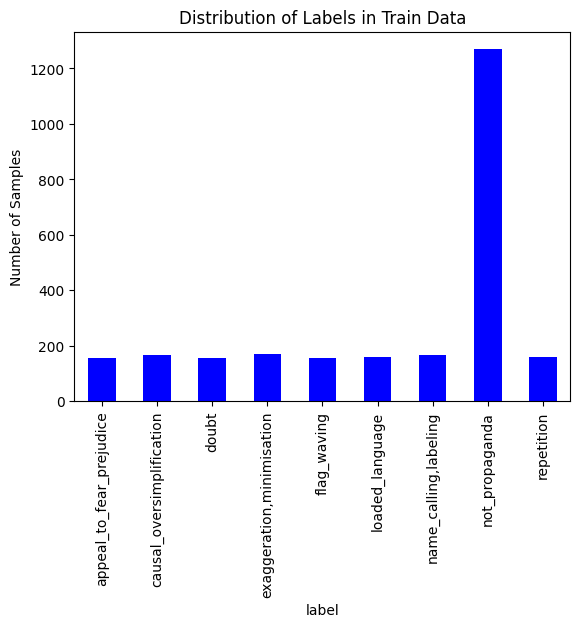

In [6]:
#checking the number of samples in each label for train data
train_df.groupby(by = "label").sentence.count().plot(kind = 'bar', color = 'blue')
plt.title("Distribution of Labels in Train Data")
plt.ylabel("Number of Samples")
plt.savefig('Distribution of Labels in Train Data.png', bbox_inches='tight')
train_df.label.value_counts()

label
not_propaganda               331
flag_waving                   45
appeal_to_fear_prejudice      43
doubt                         43
repetition                    40
loaded_language               39
causal_oversimplification     35
name_calling,labeling         34
exaggeration,minimisation     30
Name: count, dtype: int64

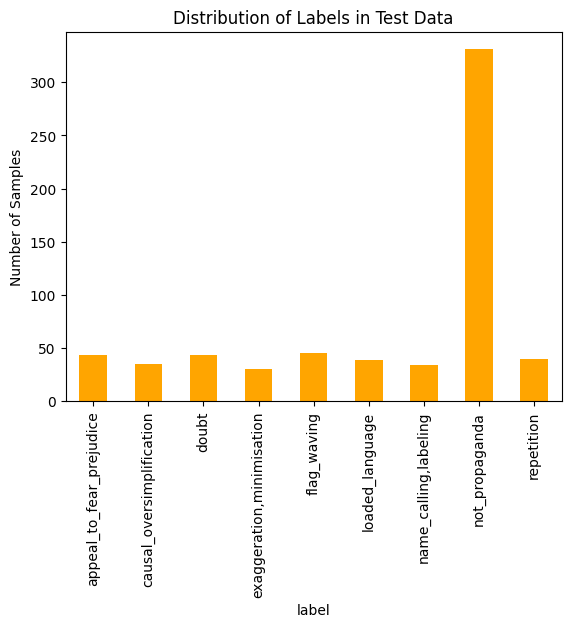

In [7]:
#checking the number of samples in each label for test data
test_df.groupby(by = "label").sentence.count().plot(kind = 'bar', color ='orange')
plt.title("Distribution of Labels in Test Data")
plt.ylabel("Number of Samples")
plt.savefig('Distribution of Labels in Test Data.png', bbox_inches='tight')
test_df.label.value_counts()

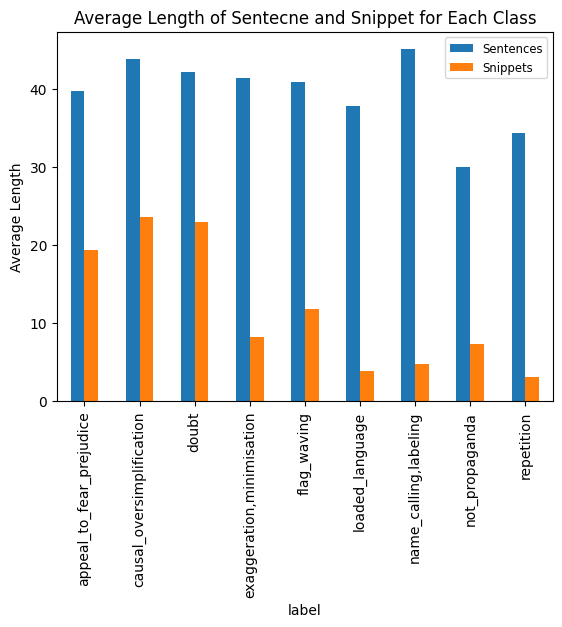

In [8]:
#checking average sentence and snippet length
train_df['sentence_lengths'] = train_df['sentence'].apply(lambda x: len(word_tokenize(x.lower())))
train_df['snippet_lengths'] = train_df['snippet'].apply(lambda x: len(word_tokenize(x.lower())))

#plotting the avergae length for each class
train_df.groupby(by = 'label')[['sentence_lengths','snippet_lengths']].mean().plot(kind = 'bar')
plt.legend(['Sentences', 'Snippets'],loc='upper right',fontsize='small')
plt.ylabel("Average Length")
plt.title("Average Length of Sentecne and Snippet for Each Class")
plt.savefig('mean_lengths_by_label.png', bbox_inches='tight')

### Defining Labels

In [9]:
#converting label column into a binary label
train_df['binary_label'] = train_df['label'].apply(lambda x: 0 if x == "not_propaganda" else 1)
test_df['binary_label'] = test_df['label'].apply(lambda x: 0 if x == "not_propaganda" else 1)

In [10]:
#converting text labels to numerical values
label_encoder = LabelEncoder()
train_df['multiclass_label'] = label_encoder.fit_transform(train_df['label'])
test_df['multiclass_label'] = label_encoder.fit_transform(test_df['label'])

In [11]:
# Displaying the label mapping
label_mapping = {label: encoded_value for label, encoded_value in zip(test_df['label'], test_df['multiclass_label'])}
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

reverse_index={value:key for (key,value)in label_mapping.items()}

not_propaganda: 7
causal_oversimplification: 1
appeal_to_fear_prejudice: 0
repetition: 8
name_calling,labeling: 6
loaded_language: 5
flag_waving: 4
doubt: 2
exaggeration,minimisation: 3


In [12]:
train_df.head()

,label,sentence,snippet,sentence_lengths,snippet_lengths,binary_label,multiclass_label
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",he,14,1,0,7
1,not_propaganda,This declassification effort <BOS> won’t make ...,won’t make things any worse than they are for...,23,14,0,7
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",American people,31,2,1,4
3,not_propaganda,“It looks like we’re capturing the demise of t...,and,49,1,0,7
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>","Location: Westerville, Ohio",11,5,0,7


In [13]:
test_df.head()

,label,sentence,snippet,binary_label,multiclass_label
0,not_propaganda,"On average, between 300 and 600 infections are...",according to a UN estimate.,0,7
1,causal_oversimplification,Mostly because <BOS> the country would not las...,the country would not last long without an ou...,1,1
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to j...,1,0
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,You,0,7
4,repetition,It must be exacted from him directly in order ...,infidels,1,8


## Bag of Words Approach With Sentence

In [14]:
#definging features and response variable
X_train_sentence = train_df["sentence"]
y_train_sentence = train_df["binary_label"]
X_test_sentence = test_df["sentence"]
y_test_sentence = test_df["binary_label"]

In [15]:
#creating bag of word representation of the sentences
vectorizer = CountVectorizer()
vectorizer.fit(X_train_sentence)
X_train_counts = vectorizer.transform(X_train_sentence)
X_test_counts = vectorizer.transform(X_test_sentence)

#replacing Count with TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_vectors = tfidf_transformer.fit_transform(X_train_counts)
X_test_vectors = tfidf_transformer.transform(X_test_counts)
#training a classifer using the BoW vectors
sentence_classifier = MultinomialNB()
sentence_classifier.fit(X_train_vectors,y_train_sentence)

#evaluating the classifier on validation set
kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)
cv_results = cross_val_score(sentence_classifier, X_train_vectors, y_train_sentence, cv = kfold, scoring = 'accuracy')
print("Cross-validation results:", cv_results)

#evaluating the classifier on test set
test_df["binary_prediction"] = sentence_classifier.predict(X_test_vectors)
print(classification_report(y_test_sentence, test_df["binary_prediction"]))

Cross-validation results: [0.66015625 0.62890625 0.6796875  0.69140625 0.68359375 0.7265625
 0.65625    0.70703125 0.6875     0.703125  ]
              precision    recall  f1-score   support

           0       0.83      0.52      0.64       331
           1       0.63      0.88      0.74       309

    accuracy                           0.70       640
   macro avg       0.73      0.70      0.69       640
weighted avg       0.73      0.70      0.69       640



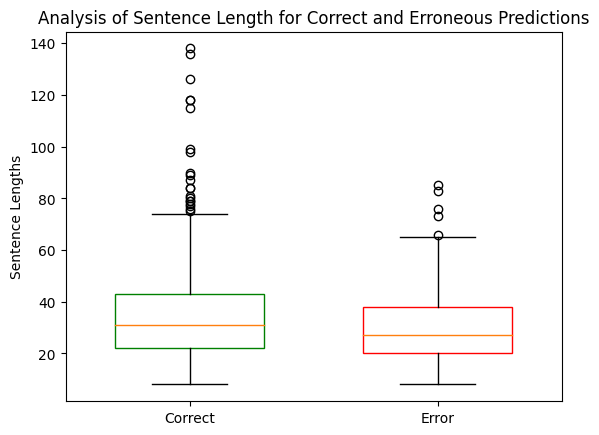

In [16]:
#analysis of errors
test_df['sentence_lengths'] = test_df['sentence'].apply(lambda x: len(word_tokenize(x.lower())))
correct_preds = test_df[test_df["binary_label"]==test_df["binary_prediction"]]
erroneous_pred = test_df[test_df["binary_label"]!=test_df["binary_prediction"]]
#plotting the predicitons
fig, ax = plt.subplots()

#Box plot for correct predictions
ax.boxplot(correct_preds['sentence_lengths'], positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor='white', color='green'))
#Box plot for errors
ax.boxplot(erroneous_pred['sentence_lengths'], positions=[2], widths=0.6, patch_artist=True, boxprops=dict(facecolor='white', color='red'))

ax.set_xticklabels(['Correct', 'Error'])
ax.set_ylabel('Sentence Lengths')
ax.set_title('Analysis of Sentence Length for Correct and Erroneous Predictions')
plt.savefig('Error anlysis - sentence.png', bbox_inches='tight')
plt.show()

## Bag of Words Approach with Snippet

In [17]:
#filtering only propaganda snippet
train_snippet_df = train_df[train_df["label"]!="not_propaganda"].copy(deep=True)
test_snippet_df = test_df[test_df["label"]!="not_propaganda"].copy(deep=True)

#divinding train and test sets
X_train_snippet = train_snippet_df['snippet']
y_train_snippet = train_snippet_df["multiclass_label"]
X_test_snippet = test_snippet_df['snippet']
y_test_snippet = test_snippet_df["multiclass_label"]

#creating tf-idf vectors
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_snippet)
X_train_tfidf = vectorizer.transform(X_train_snippet)
X_test_tfidf = vectorizer.transform(X_test_snippet)

#multi-class classification with MultinomialNB
snippet_classifier = MultinomialNB()
snippet_classifier.fit(X_train_tfidf,y_train_snippet)

#evaluating the classifier on validation set
kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)
cv_results = cross_val_score(snippet_classifier, X_train_tfidf, y_train_snippet, cv = kfold, scoring = 'accuracy')
print("Cross-validation results:", cv_results)

#evaluating the classifier on test set
test_snippet_df["multiclass_prediction"] = snippet_classifier.predict(X_test_tfidf)
print(classification_report(y_test_snippet, test_snippet_df["multiclass_prediction"]))

Cross-validation results: [0.38461538 0.43410853 0.46511628 0.41860465 0.41860465 0.44186047
 0.40310078 0.4496124  0.34883721 0.43410853]
              precision    recall  f1-score   support

           0       0.56      0.47      0.51        43
           1       0.29      0.86      0.44        35
           2       0.40      0.44      0.42        43
           3       0.33      0.43      0.37        30
           4       0.66      0.60      0.63        45
           5       0.73      0.21      0.32        39
           6       0.50      0.26      0.35        34
           8       0.79      0.28      0.41        40

    accuracy                           0.44       309
   macro avg       0.53      0.44      0.43       309
weighted avg       0.54      0.44      0.44       309



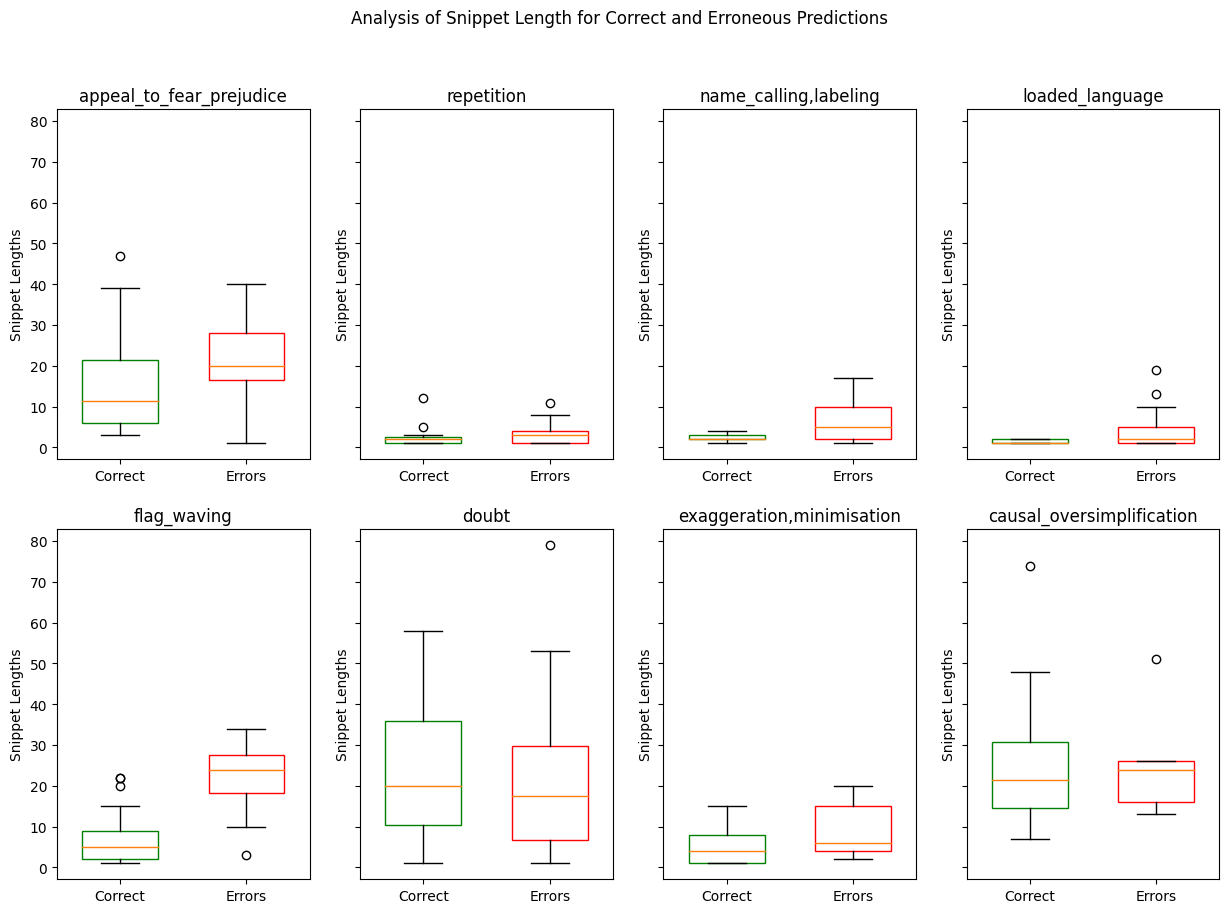

In [18]:
#analysising errors
test_snippet_df['snippet_lengths'] = test_snippet_df['snippet'].apply(lambda x: len(word_tokenize(x.lower())))
correct_preds = test_snippet_df[test_snippet_df["multiclass_label"]==test_snippet_df["multiclass_prediction"]]
erroneous_pred = test_snippet_df[test_snippet_df["multiclass_label"]!=test_snippet_df["multiclass_prediction"]]

# Creating figure to plot spearate box-plots for each class
labels = test_snippet_df['label'].unique()
fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharey=True)
axs = axs.flatten()

#looping through each label and creating box plots
for i, label in enumerate(labels):
    # Filtering data for correct predictions and errors for the current label
    correct_lengths = correct_preds[correct_preds['label'] == label]['snippet_lengths']
    error_lengths = erroneous_pred[erroneous_pred['label'] == label]['snippet_lengths']

    #plotting the box-plots
    axs[i-1].boxplot(correct_lengths, positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor='white', color='green'))
    axs[i-1].boxplot(error_lengths, positions=[2], widths=0.6, patch_artist=True, boxprops=dict(facecolor='white', color='red'))
    axs[i-1].set_xticklabels(['Correct', 'Errors'])
    axs[i-1].set_title(f'{label}')
    axs[i-1].set_ylabel('Snippet Lengths')


plt.suptitle('Analysis of Snippet Length for Correct and Erroneous Predictions')
plt.savefig('Error anlysis - snippet.png', bbox_inches='tight')
plt.show()

In [19]:
erroneous_pred[erroneous_pred['label'] == 'doubt']['snippet_lengths']

39     14
44      6
52     79
53      1
61     53
101    19
124    35
127    27
150    11
153     1
178    24
190     1
298    53
388     6
442    10
464    28
477    39
487    16
494     6
593    28
597    20
602    48
622     9
624     7
Name: snippet_lengths, dtype: int64

In [20]:
erroneous_pred[erroneous_pred['label'] == 'flag_waving']['snippet']

77      The American people are not going to put up w...
79      Latino Voters Show Trump What It Means to Be ...
90      Instead of reaching out to the greatest demog...
97      we hope and pray that all the good U.S. bisho...
134     But it is also about freedom of speech, about...
165     In a nation guided by fairness and law, a per...
248     European nations which have encouraged migrat...
261     We are supposed to serve as an example to the...
265     And only one force in the region has the powe...
272     Maybe he should have taken the time to look t...
321     They are weak and pathetic and they have no e...
323                                   the United States 
327     If you (Americans) are committed to counterin...
349     Could the good people of Massachusetts do us ...
370     I applaud the brave men and women of ICE who ...
415     the “establishment of an Islamic state…requir...
510     9 concrete steps that, if implemented by a fu...
638     He also sang an Islamic

## BERT Approach

### Implementing BERT

In [21]:
#this function tokenizes the data and creates tensors for input_ids, attention_masks and labels
def tokenize_data(sentences, labels):
    #initialize input IDs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate over each sentence and encode the sentence using the tokenizer
    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,  #Add special tokens like [CLS] and [SEP]
            max_length=64,  #Maximum length of the input sequence
            padding='max_length',  #Pad the input sequence to the maximum length
            truncation=True,  #Truncate the input sequence if it exceeds the maximum length
            return_attention_mask=True,  #Return an attention mask tensor
            return_tensors='pt'  #Return PyTorch tensors
        )

        #storing the input IDs and attention masks to the respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    #converting the lists of input IDs and attention masks to PyTorch tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    #converting the labels to a PyTorch tensor
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [22]:
#This functions prepares the dataset for BERT model
def create_dataloaders(feature, label, batch_size):
    #selecting features and labels
    X_train = train_df[feature]
    y_train = train_df[label]
    X_val = test_df[feature]
    y_val = test_df[label]

    #creating tensor of input_ids, attention_masks and labels for training and validation sets
    train_input_ids, train_attention_masks, train_labels = tokenize_data(X_train, y_train)
    val_input_ids, val_attention_masks, val_labels = tokenize_data(X_val, y_val)

    #creating DataLoader for training set
    train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    #creating DataLoader for validation set
    val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader,val_dataloader

In [23]:
#This function trains the BERT model
def train(model, train_dataloader, val_dataloader, epochs, alpha, device, patience = 10, random_seed = 42, verbose = True):
    # Seting random seed for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    #creating a copy to keep track of best model
    best_model = copy.deepcopy(model)
    best_val_accuracy = 0.0

    #creating an optimizer instance with the model parameters and the specified learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=alpha)
    val_losses = []
    val_results = []

    #looping over the specified number of epochs
    for epoch in range(epochs):
        #Set the model to training mode
        model.train()
        total_loss = 0
        #looping over the training data batches
        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)  #moving the batch tensors to the specified device (CPU or GPU)
            input_ids, attention_mask, labels = batch  #unpacking the batch tensors
            optimizer.zero_grad()  #reseting the gradients to zero

            #forward pass through the model to obtain the outputs and calculate the loss for the current batch
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            #backward pass to compute the gradients of the loss and update the model parameters using the gradients and the optimizer
            loss.backward()
            optimizer.step()

        #calculating the average training loss for the epoch
        avg_train_loss = total_loss / len(train_dataloader)


        #Set the model to evaluation mode
        model.eval()
        val_loss = 0
        val_accuracy = 0
        #looping over the validation data batches
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            with torch.no_grad():  #disabling gradient computation for evaluation
                #forward pass through the model
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss  #extract the loss value from the model outputs
            logits = outputs.logits  #extract the raw scores before applying softmax
            val_loss += loss.item()  #calculating the validation loss for current bath
            preds = torch.argmax(logits, dim=1).flatten()  #calculating the predicted labels based on the maximum logits
            val_accuracy += torch.sum(preds == labels).item() #calculating the number of correct predictions for the current batch

        avg_val_loss = val_loss / len(val_dataloader)  #calculating the average validation loss for the epoch
        val_accuracy /= VAL_SAMPLES  #calculating the validation accuracy

        #printing the results for the current epoch
        val_losses.append(avg_val_loss)
        val_results.append(val_accuracy)
        if verbose:
            print(f'Epoch {epoch + 1}/{epochs}')
            print(f'Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        #Save the best model and apply early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        #Early stopping
        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Save the best model
    torch.save(best_model.state_dict(), f'best_model_{alpha}.pt')
    return val_losses,val_results

### BERT for Sentence

In [24]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#loading a pre-trained BERTtokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

#preparing the feature and label for BERT model
feature = 'sentence'
label = 'binary_label'
batch_size = 32
train_dataloader, val_dataloader = create_dataloaders(feature, label, batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
#defining sone hyperparameters
EPOCHS = 10
ALPHAS = [1e-3,1e-4,1e-5,1e-6]
VAL_SAMPLES = len(test_df)

#training the model for different learning rates
sen_losses = []
sen_accuracies = []
for alpha in ALPHAS:
    binary_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    binary_model.to(device)
    loss, accuracy = train(binary_model, train_dataloader, val_dataloader, EPOCHS, alpha, device)
    sen_losses.append(loss)
    sen_accuracies.append(accuracy)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 0.7334, Validation Loss: 0.7177, Validation Accuracy: 0.4828
Epoch 2/10
Training Loss: 0.7161, Validation Loss: 0.7370, Validation Accuracy: 0.4828
Epoch 3/10
Training Loss: 0.7052, Validation Loss: 0.6990, Validation Accuracy: 0.5172
Epoch 4/10
Training Loss: 0.7030, Validation Loss: 0.6961, Validation Accuracy: 0.4828
Epoch 5/10
Training Loss: 0.7009, Validation Loss: 0.6988, Validation Accuracy: 0.5172
Epoch 6/10
Training Loss: 0.6994, Validation Loss: 0.6927, Validation Accuracy: 0.5172
Epoch 7/10
Training Loss: 0.6988, Validation Loss: 0.7091, Validation Accuracy: 0.4828
Epoch 8/10
Training Loss: 0.6994, Validation Loss: 0.6926, Validation Accuracy: 0.5172
Epoch 9/10
Training Loss: 0.6966, Validation Loss: 0.6926, Validation Accuracy: 0.5172
Epoch 10/10
Training Loss: 0.6964, Validation Loss: 0.6959, Validation Accuracy: 0.4828


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 0.4512, Validation Loss: 0.2727, Validation Accuracy: 0.8953
Epoch 2/10
Training Loss: 0.1396, Validation Loss: 0.2313, Validation Accuracy: 0.9109
Epoch 3/10
Training Loss: 0.0810, Validation Loss: 0.3261, Validation Accuracy: 0.9016
Epoch 4/10
Training Loss: 0.0507, Validation Loss: 0.2607, Validation Accuracy: 0.9094
Epoch 5/10
Training Loss: 0.0528, Validation Loss: 0.4889, Validation Accuracy: 0.8969
Epoch 6/10
Training Loss: 0.0299, Validation Loss: 0.5260, Validation Accuracy: 0.8984
Epoch 7/10
Training Loss: 0.0283, Validation Loss: 0.3528, Validation Accuracy: 0.9094
Epoch 8/10
Training Loss: 0.0151, Validation Loss: 0.3311, Validation Accuracy: 0.9141
Epoch 9/10
Training Loss: 0.0146, Validation Loss: 0.3491, Validation Accuracy: 0.9078
Epoch 10/10
Training Loss: 0.0042, Validation Loss: 0.4527, Validation Accuracy: 0.9297


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 0.5936, Validation Loss: 0.4388, Validation Accuracy: 0.8250
Epoch 2/10
Training Loss: 0.3241, Validation Loss: 0.2783, Validation Accuracy: 0.8859
Epoch 3/10
Training Loss: 0.1762, Validation Loss: 0.2298, Validation Accuracy: 0.9109
Epoch 4/10
Training Loss: 0.1024, Validation Loss: 0.2289, Validation Accuracy: 0.9203
Epoch 5/10
Training Loss: 0.0645, Validation Loss: 0.2260, Validation Accuracy: 0.9266
Epoch 6/10
Training Loss: 0.0363, Validation Loss: 0.2213, Validation Accuracy: 0.9375
Epoch 7/10
Training Loss: 0.0234, Validation Loss: 0.2533, Validation Accuracy: 0.9375
Epoch 8/10
Training Loss: 0.0200, Validation Loss: 0.2621, Validation Accuracy: 0.9328
Epoch 9/10
Training Loss: 0.0195, Validation Loss: 0.2227, Validation Accuracy: 0.9422
Epoch 10/10
Training Loss: 0.0097, Validation Loss: 0.2807, Validation Accuracy: 0.9297


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 0.7123, Validation Loss: 0.6832, Validation Accuracy: 0.5531
Epoch 2/10
Training Loss: 0.6759, Validation Loss: 0.6557, Validation Accuracy: 0.6406
Epoch 3/10
Training Loss: 0.6317, Validation Loss: 0.6174, Validation Accuracy: 0.6719
Epoch 4/10
Training Loss: 0.5960, Validation Loss: 0.5816, Validation Accuracy: 0.6922
Epoch 5/10
Training Loss: 0.5533, Validation Loss: 0.5308, Validation Accuracy: 0.7641
Epoch 6/10
Training Loss: 0.5047, Validation Loss: 0.4899, Validation Accuracy: 0.7969
Epoch 7/10
Training Loss: 0.4517, Validation Loss: 0.4597, Validation Accuracy: 0.8125
Epoch 8/10
Training Loss: 0.4231, Validation Loss: 0.4266, Validation Accuracy: 0.8219
Epoch 9/10
Training Loss: 0.3789, Validation Loss: 0.3985, Validation Accuracy: 0.8297
Epoch 10/10
Training Loss: 0.3465, Validation Loss: 0.3698, Validation Accuracy: 0.8531


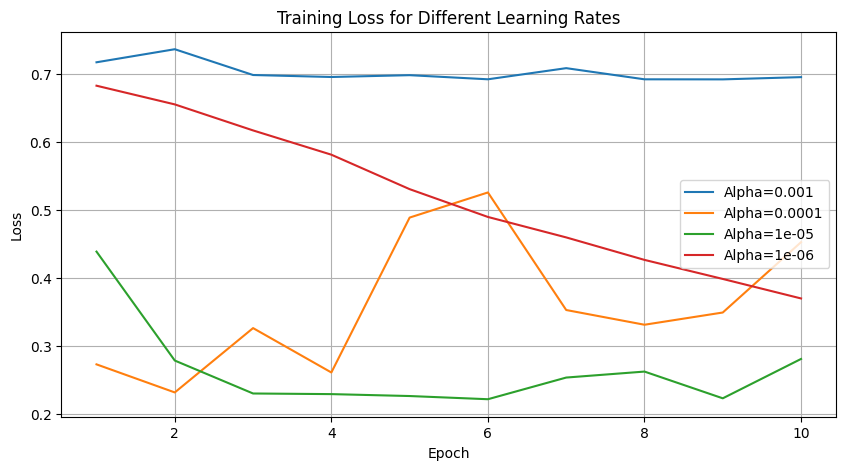

In [26]:
#Ploting loss
plt.figure(figsize=(10, 5))
for alpha, loss in zip(ALPHAS, sen_losses):
    plt.plot(range(1, EPOCHS + 1), loss, label=f'Alpha={alpha}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.savefig('loss anlysis - sentence.png', bbox_inches='tight')
plt.show()

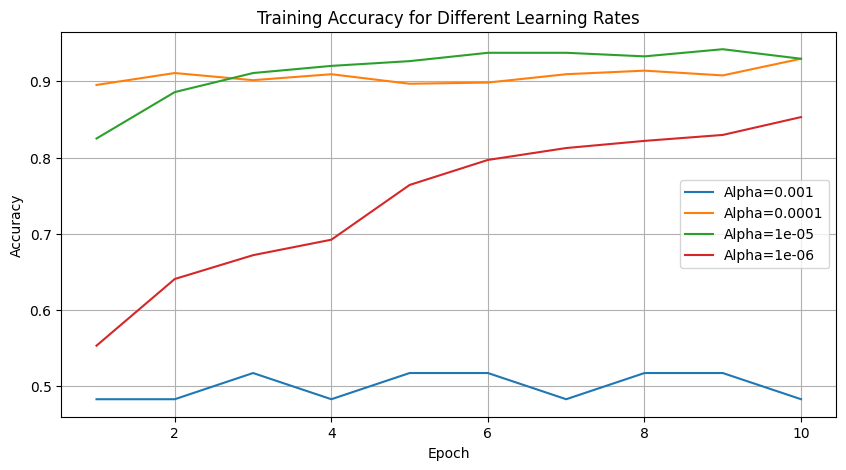

In [27]:
# Ploting accuracy
plt.figure(figsize=(10, 5))
for alpha, accuracy in zip(ALPHAS, sen_accuracies):
    plt.plot(range(1, EPOCHS + 1), accuracy, label=f'Alpha={alpha}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.savefig('score anlysis - sentence.png', bbox_inches='tight')
plt.show()

In [39]:
#loading the best model for binary clasiification
binary_model.load_state_dict(torch.load(f'best_model_{1e-5}.pt'))

In [30]:
#testing the model with best performance
def evaluate(model,test_dataloader):
    model.eval()
    val_loss = 0
    val_accuracy = 0
    total_acc_test = 0
    with torch.no_grad():
        predictions=[]
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)  #moving the batch tensors to the specified device (CPU or GPU)
            input_ids, attention_mask, labels = batch  #unpacking the batch tensors
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits  # Access the logits attribute
            preds = torch.argmax(logits, dim=1).flatten()  # Compute argmax on logits
            predictions.append(preds)
            total_acc_test+= torch.sum(preds == labels).item()

    print(f'Test accuracy: {total_acc_test/VAL_SAMPLES: .3f}')
    return predictions

predictions = evaluate(binary_model,val_dataloader)

Test accuracy:  0.942


In [32]:
#generating the classification report
pred_labels = []
for batch in predictions:
    for pred in batch:
        pred_labels.append(pred.item())

test_df['BERTsentence_Prediction'] = pred_labels

print(classification_report(test_df['binary_label'], test_df['BERTsentence_Prediction']))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       331
           1       0.95      0.93      0.94       309

    accuracy                           0.94       640
   macro avg       0.94      0.94      0.94       640
weighted avg       0.94      0.94      0.94       640



### BERT for Snippet

In [33]:
#preparing the feature and label for BERT model
feature = 'snippet'
label = 'multiclass_label'
snippet_train_dataloader, snippet_val_dataloader = create_dataloaders(feature, label, batch_size)

In [34]:
#defining hyperparameters
EPOCHS = 10
ALPHAS = [1e-3,1e-4,1e-5,1e-6]
VAL_SMAPLES = len(test_df)

#training the model for different learning rates
snippet_losses = []
snippet_accuracies = []
for alpha in ALPHAS:
    snippet_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9)
    snippet_model.to(device)
    loss, accuracy = train(snippet_model, snippet_train_dataloader, snippet_val_dataloader, EPOCHS, alpha, device)
    snippet_losses.append(loss)
    snippet_accuracies.append(accuracy)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 1.8532, Validation Loss: 1.7125, Validation Accuracy: 0.5172
Epoch 2/10
Training Loss: 1.7751, Validation Loss: 1.8053, Validation Accuracy: 0.5172
Epoch 3/10
Training Loss: 1.7730, Validation Loss: 1.7124, Validation Accuracy: 0.5172
Epoch 4/10
Training Loss: 1.7711, Validation Loss: 1.7045, Validation Accuracy: 0.5172
Epoch 5/10
Training Loss: 1.7585, Validation Loss: 1.8112, Validation Accuracy: 0.5172
Epoch 6/10
Training Loss: 1.7459, Validation Loss: 1.8176, Validation Accuracy: 0.5172
Epoch 7/10
Training Loss: 1.7320, Validation Loss: 1.7372, Validation Accuracy: 0.5172
Epoch 8/10
Training Loss: 1.7316, Validation Loss: 1.9181, Validation Accuracy: 0.5172
Epoch 9/10
Training Loss: 1.7351, Validation Loss: 1.7226, Validation Accuracy: 0.5172
Epoch 10/10
Training Loss: 1.7189, Validation Loss: 1.8114, Validation Accuracy: 0.5172


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 1.3630, Validation Loss: 0.9748, Validation Accuracy: 0.6859
Epoch 2/10
Training Loss: 0.7512, Validation Loss: 0.8980, Validation Accuracy: 0.7078
Epoch 3/10
Training Loss: 0.4133, Validation Loss: 0.9269, Validation Accuracy: 0.7250
Epoch 4/10
Training Loss: 0.2252, Validation Loss: 1.0697, Validation Accuracy: 0.7203
Epoch 5/10
Training Loss: 0.1491, Validation Loss: 1.1679, Validation Accuracy: 0.7156
Epoch 6/10
Training Loss: 0.1010, Validation Loss: 1.2353, Validation Accuracy: 0.7250
Epoch 7/10
Training Loss: 0.0998, Validation Loss: 1.1917, Validation Accuracy: 0.7312
Epoch 8/10
Training Loss: 0.0807, Validation Loss: 1.2065, Validation Accuracy: 0.7391
Epoch 9/10
Training Loss: 0.0618, Validation Loss: 1.2894, Validation Accuracy: 0.7359
Epoch 10/10
Training Loss: 0.0763, Validation Loss: 1.2549, Validation Accuracy: 0.7328


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 1.7439, Validation Loss: 1.4784, Validation Accuracy: 0.5172
Epoch 2/10
Training Loss: 1.3738, Validation Loss: 1.2035, Validation Accuracy: 0.5859
Epoch 3/10
Training Loss: 1.1335, Validation Loss: 1.0686, Validation Accuracy: 0.6500
Epoch 4/10
Training Loss: 0.9399, Validation Loss: 0.9884, Validation Accuracy: 0.6797
Epoch 5/10
Training Loss: 0.7652, Validation Loss: 0.9376, Validation Accuracy: 0.6953
Epoch 6/10
Training Loss: 0.6160, Validation Loss: 0.8776, Validation Accuracy: 0.7109
Epoch 7/10
Training Loss: 0.4925, Validation Loss: 0.8663, Validation Accuracy: 0.7328
Epoch 8/10
Training Loss: 0.3782, Validation Loss: 0.8629, Validation Accuracy: 0.7438
Epoch 9/10
Training Loss: 0.3038, Validation Loss: 0.8523, Validation Accuracy: 0.7328
Epoch 10/10
Training Loss: 0.2280, Validation Loss: 0.8799, Validation Accuracy: 0.7422


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 2.1400, Validation Loss: 1.9439, Validation Accuracy: 0.4875
Epoch 2/10
Training Loss: 1.8786, Validation Loss: 1.7829, Validation Accuracy: 0.5125
Epoch 3/10
Training Loss: 1.7776, Validation Loss: 1.7036, Validation Accuracy: 0.5141
Epoch 4/10
Training Loss: 1.7105, Validation Loss: 1.6450, Validation Accuracy: 0.5156
Epoch 5/10
Training Loss: 1.6640, Validation Loss: 1.5960, Validation Accuracy: 0.5156
Epoch 6/10
Training Loss: 1.6254, Validation Loss: 1.5476, Validation Accuracy: 0.5156
Epoch 7/10
Training Loss: 1.5741, Validation Loss: 1.5015, Validation Accuracy: 0.5156
Epoch 8/10
Training Loss: 1.5236, Validation Loss: 1.4601, Validation Accuracy: 0.5203
Epoch 9/10
Training Loss: 1.4807, Validation Loss: 1.4247, Validation Accuracy: 0.5219
Epoch 10/10
Training Loss: 1.4406, Validation Loss: 1.3872, Validation Accuracy: 0.5297


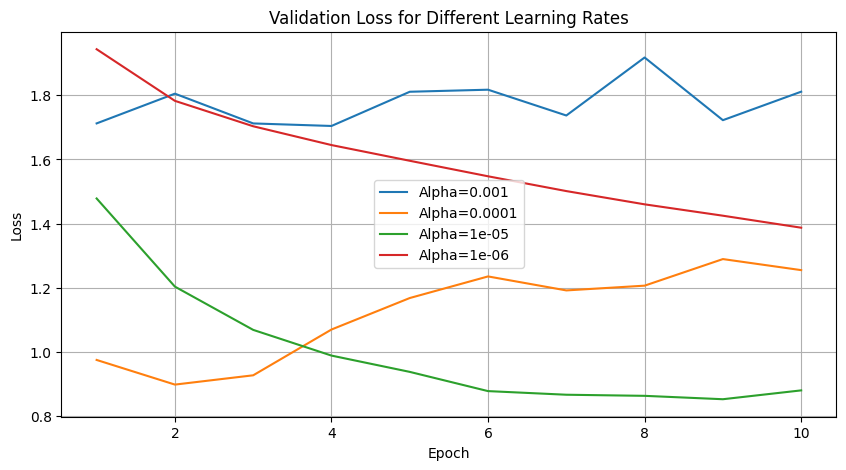

In [35]:
#Ploting loss
plt.figure(figsize=(10, 5))
for alpha, loss in zip(ALPHAS, snippet_losses):
    plt.plot(range(1, EPOCHS + 1), loss, label=f'Alpha={alpha}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.savefig('loss anlysis - snippet.png', bbox_inches='tight')
plt.show()

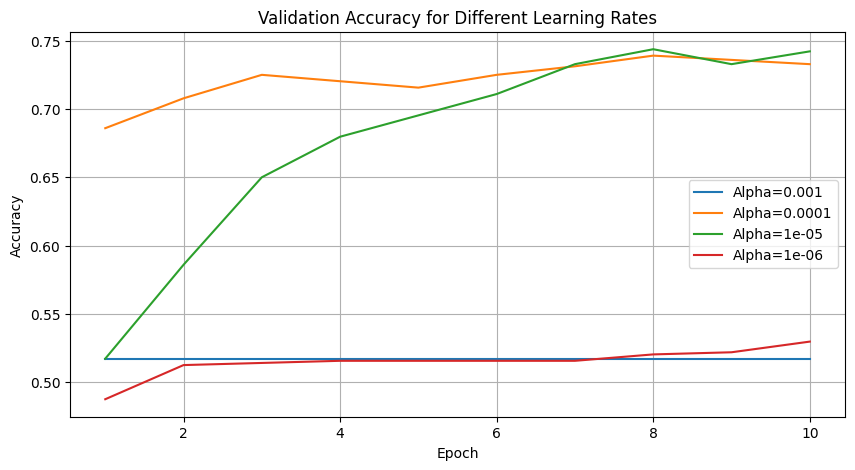

In [36]:
# Ploting accuracy
plt.figure(figsize=(10, 5))
for alpha, accuracy in zip(ALPHAS, snippet_accuracies):
    plt.plot(range(1, EPOCHS + 1), accuracy, label=f'Alpha={alpha}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.savefig('score anlysis - snippet.png', bbox_inches='tight')
plt.show()

In [37]:
#loading the best snippet classifier model
snippet_model.load_state_dict(torch.load(f'best_model_{1e-5}.pt'))

<All keys matched successfully>

In [38]:
#getting the classification report
snippet_predictions = evaluate(snippet_model,snippet_val_dataloader)

pred_labels = []
for batch in snippet_predictions:
    for pred in batch:
        pred_labels.append(pred.item())

test_df['BERTsnippet_Prediction'] = pred_labels
print(classification_report(test_df['multiclass_label'], test_df['BERTsnippet_Prediction']))

Test accuracy:  0.744
              precision    recall  f1-score   support

           0       0.59      0.60      0.60        43
           1       0.54      0.74      0.63        35
           2       0.59      0.51      0.55        43
           3       0.58      0.50      0.54        30
           4       0.74      0.62      0.67        45
           5       0.65      0.62      0.63        39
           6       0.71      0.59      0.65        34
           7       0.88      0.90      0.89       331
           8       0.39      0.45      0.42        40

    accuracy                           0.74       640
   macro avg       0.63      0.61      0.62       640
weighted avg       0.75      0.74      0.74       640

